In [ ]:
!pip install nlpaug
!pip install ktrain

import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Dropout, Flatten, Dense, Conv1D, MaxPooling1D, Bidirectional, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from textblob import Word
import re
from google.colab import drive
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')
path = 'drive/My Drive/Colab Notebooks/public-data/text_data'

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


###########     Data Pre-processing     ###################


df = pd.read_csv(path+'/public_data.csv')
df['text'] = df['text'].fillna("")
df['label'] = df['label'].astype(int)

# Preprocess text data and clean as needed
df['lower_case'] = df['text'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))
df['alphabatic'] = df['lower_case'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x)).apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
df['without-link'] = df['alphabatic'].apply(lambda x: re.sub(r'http\S+', '', x))

tokenizer = RegexpTokenizer(r'\w+')
df['Special_word'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)
stop = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]
df['stop_words'] = df['Special_word'].apply(lambda x: [item for item in x if item not in stop])
df['stop_words'] = df['stop_words'].astype('str')
df['short_word'] = df['stop_words'].str.findall('\w{2,}')
df['string'] = df['short_word'].str.join(' ')
df['Text'] = df['string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Drop specific non-integer values and rows with NaN in 'label'
indexes_to_drop = df[df['label'].isin(['|', '11', '22', '32', '21'])].index
df.drop(indexes_to_drop, inplace=True)
df = df.dropna(subset=['label'])
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype('int32')




# Augmentation function
def augment_text(df, augmenter, repetitions=1):
    aug_texts = []
    for _, row in df.iterrows():
        text = row['text']
        for _ in range(repetitions):
            augmented_text = augmenter.augment(text)
            aug_texts.append((augmented_text, row['label']))
    return pd.DataFrame(aug_texts, columns=['text', 'label'])

# Synonym Augmenter
augmenter = naw.SynonymAug(aug_src='wordnet')

# Upsampling using augmentation
max_size = df['label'].value_counts().max()
df_balanced = pd.DataFrame()
for label in df['label'].unique():
    df_class = df[df['label'] == label]
    df_class_aug = augment_text(df_class, augmenter, repetitions=max_size // len(df_class) - 1)
    df_balanced = pd.concat([df_balanced, df_class, df_class_aug])

# Print class distribution after augmentation
print("\nClass distribution after augmentation:")
print(df_balanced['label'].value_counts())

df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)



# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)






##############          Tokenization and Splitting    #########################




# Tokenization parameters
vocab_size = 20000
max_length = 300

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)  # Add this line
sequences_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(sequences_train, maxlen=max_length)
X_val_padded = pad_sequences(sequences_val, maxlen=max_length)  # Add this line
X_test_padded = pad_sequences(sequences_test, maxlen=max_length)



      ############### Model Using   #############################

# Define model
model_cl = Sequential()
model_cl.add(Embedding(20000, 128, input_length=300))
model_cl.add(SpatialDropout1D(0.8))
model_cl.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Bidirectional(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model_cl.add(Dropout(0.5))
model_cl.add(Bidirectional(LSTM(50, dropout=0.5, recurrent_dropout=0.5)))
model_cl.add(Dropout(0.5))
model_cl.add(Flatten())
model_cl.add(Dense(32, activation='relu'))
model_cl.add(Dropout(0.5))
model_cl.add(Dense(len(df['label'].unique()), activation='softmax'))

model_cl.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

# Callbacks adjusted for training with validation
checkpoint_callback = ModelCheckpoint(filepath="cnn_lstm_best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)



# Convert labels to tensors
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Train the model
history_cl = model_cl.fit(
    X_train_padded, y_train_tensor,
    validation_data=(X_val_padded, y_val_tensor),
    epochs=20,
    batch_size=20,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_cl.evaluate(X_test_padded, y_test_tensor, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.2-py3-none-any.whl size=25317058 sha256=e88cae373a8ff661dc012be0926f85e7e831d356aa31fa546f9488

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.



Class distribution after augmentation:
0    4536
1    4521
2    4494
3    4465
Name: label, dtype: int64
Epoch 1/20
721/721 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.4720
Epoch 1: val_accuracy improved from -inf to 0.48613, saving model to cnn_lstm_best_model.h5
721/721 [==============================] - 657s 891ms/step - loss: 1.0054 - accuracy: 0.4720 - val_loss: 0.9120 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


721/721 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.4926
Epoch 2: val_accuracy did not improve from 0.48613
721/721 [==============================] - 648s 900ms/step - loss: 0.9281 - accuracy: 0.4926 - val_loss: 0.9118 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 3/20
721/721 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.4987
Epoch 3: val_accuracy improved from 0.48613 to 0.48835, saving model to cnn_lstm_best_model.h5
721/721 [==============================] - 634s 879ms/step - loss: 0.9007 - accuracy: 0.4987 - val_loss: 0.9243 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 4/20
721/721 [==============================] - ETA: 0s - loss: 0.8841 - accuracy: 0.5001
Epoch 4: val_accuracy did not improve from 0.48835
721/721 [==============================] - 630s 873ms/step - loss: 0.8841 - accuracy: 0.5001 - val_loss: 0.9294 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 5/20
721/721 [==============================] - ETA: 0s - loss: 0.8692 - acc

# Confusion Matrix

57/57 [==============================] - 12s 172ms/step

Average Precision: 0.3162659155230081
Average Recall: 0.4915748461385745
Average F1 Score: 0.36293308464918633
Precision for each class: [0.94008264 0.         0.         0.32498102]
Recall for each class: [0.98913043 0.         0.         0.97716895]
F1 Score for each class: [0.96398305 0.         0.         0.48774929]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


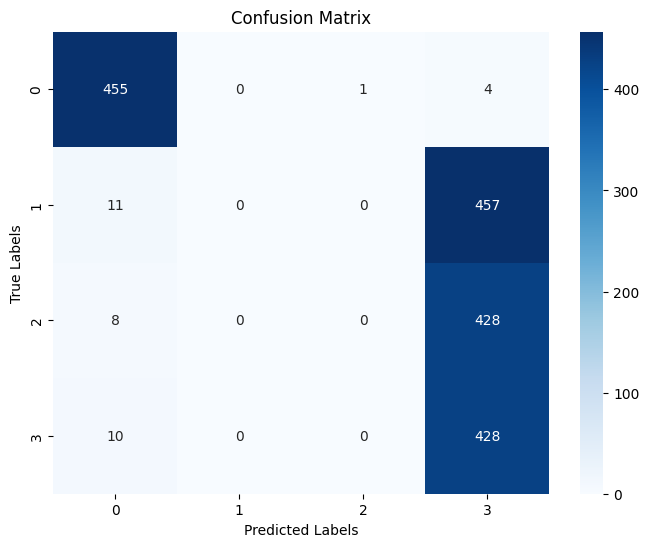

In [ ]:
# Predicting the labels on test set
y_pred_prob = model_cl.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_test_tensor is a NumPy array
y_test_array = y_test_tensor.numpy() if hasattr(y_test_tensor, 'numpy') else np.array(y_test_tensor)

# If y_test_tensor or y_test are one-hot encoded, convert them back to label encoding
if len(y_test_array.shape) > 1:
    y_test_array = np.argmax(y_test_array, axis=1)


# Compute average precision, recall, and F1-score
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(y_test_array, y_pred, average='macro')

print('\nAverage Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average F1 Score:', avg_f1)




# Compute precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_array, y_pred, average=None)

print('Precision for each class:', precision)
print('Recall for each class:', recall)
print('F1 Score for each class:', f1)



# Compute confusion matrix
class_names = sorted(df_balanced['label'].unique())  # Assuming 'class_names' matches the order of your classes
cm = confusion_matrix(y_test_array, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# Confusion Matrix for Four Classes

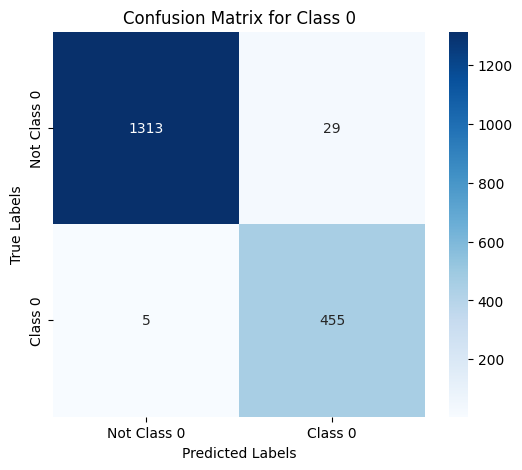

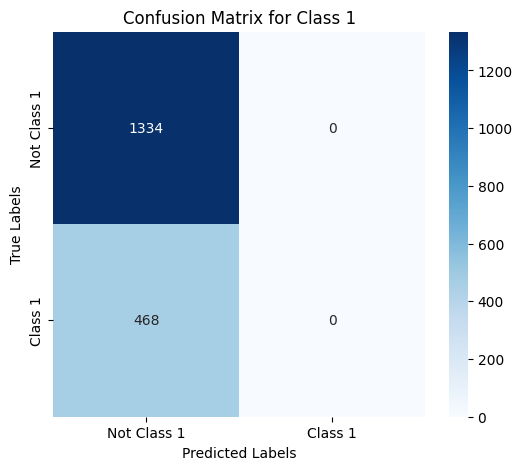

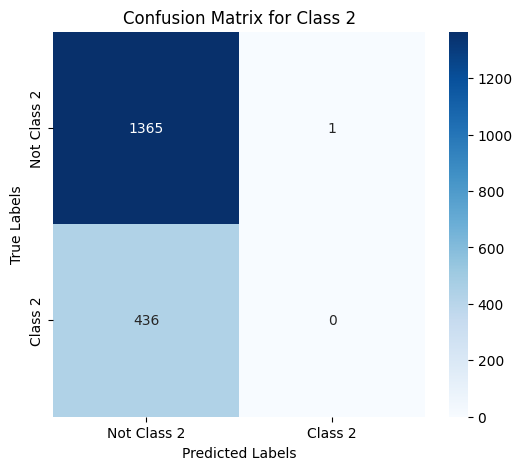

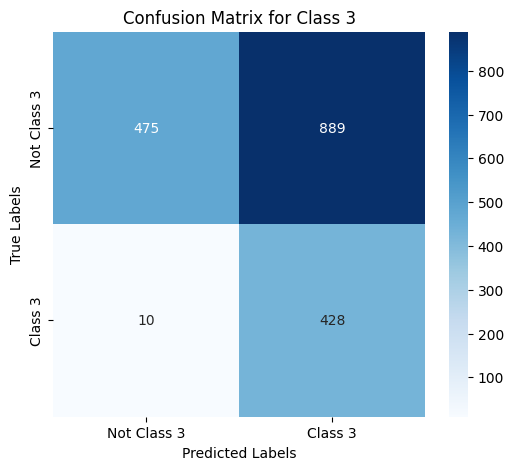

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_confusion_matrix(cm, class_id, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Not ' + class_names[class_id], class_names[class_id]],
                yticklabels=['Not ' + class_names[class_id], class_names[class_id]])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {class_names[class_id]}')
    plt.show()

for i in range(num_classes):
    # Create binary labels for each class
    y_test_binary = np.where(y_test_array == i, 1, 0)
    y_pred_binary = np.where(y_pred == i, 1, 0)

    # Compute confusion matrix for each class
    cm = confusion_matrix(y_test_binary, y_pred_binary)

    # Plot confusion matrix
    plot_confusion_matrix(cm, i, class_names)

# Accuracy for each classes

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
num_classes = len(class_names)



# Function to calculate the accuracy for one class
def calculate_class_accuracy(cm):

    return (cm[1, 1] + cm[0, 0]) / np.sum(cm)

for i in range(num_classes):
    # Create binary labels for each class
    y_test_binary = np.where(y_test == i, 1, 0)
    y_pred_binary = np.where(y_pred == i, 1, 0)

    # Compute confusion matrix for each class
    cm = confusion_matrix(y_test_binary, y_pred_binary)

    # Calculate accuracy
    accuracy = calculate_class_accuracy(cm)

    # Print accuracy
    print(f'Accuracy for {class_names[i]}: {accuracy:.2f}')


Accuracy for Class 0: 0.98
Accuracy for Class 1: 0.74
Accuracy for Class 2: 0.76
Accuracy for Class 3: 0.50


ROC-AUC

57/57 [==============================] - 9s 155ms/step


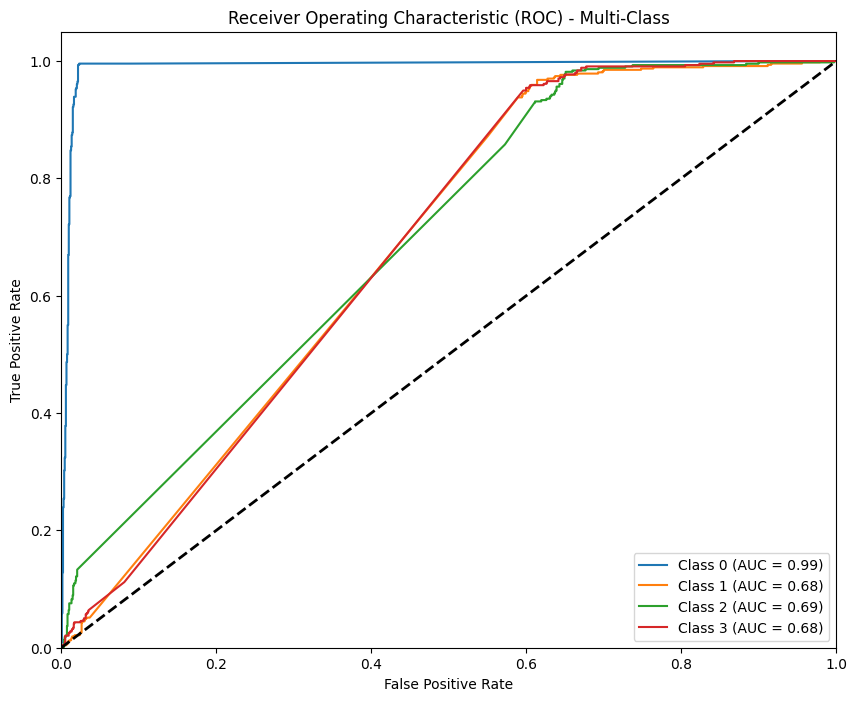

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Predict class probabilities on the test set
y_pred_prob = model_cl.predict(X_test_padded)

# One-hot encode the true test labels
y_test_one_hot = to_categorical(y_test_tensor, num_classes=model_cl.output_shape[-1])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(model_cl.output_shape[-1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(model_cl.output_shape[-1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()
